# Анализ данных HR отдела
## Источник данных
Набор данных - [Human Resources Data Set](https://www.kaggle.com/rhuebner/human-resources-data-set) разработан Dr. Rich и периодически обновляется.  
Сейчас доступна 13 версия [Codebook - HR Dataset v13](https://rpubs.com/rhuebner/HRCodebook-13) от 9/27/2019  
Также данный набор данных анализировался:  
  * Kathy Sun - в рамках её проекта [Final Project for R](https://rpubs.com/KathySun1/FinalProject)
  * CSV файлы с данными v.9 были получены из [github](https://github.com/patrol7171/HR-Data-Analysis--Dental-Magic/tree/ef3c3dc7169bfec77f35d7fb5e3aced1ef767c58) Patricia Rollins  
  
Данные анализировались в рамках курсового проекат универиситета Skillbox и изначально были представлены БД PostgreSQL на сервере университета.  
  
*Для соблюдение конфиденциальности БД компании Skillbox, при опубликовании данного проекта используется SQLite в которую распакованы таблицы с данными из файлов CSV.*

## Для публичного размещения сделаем следующее:
1. Преобразуем данные из CSV-файлов из репозитория Patricia Rollins в таблицы в БД SQLite (HR.db)
2. В ходе преобразования сделаем следующие корректировки (для соответствия с БД Skillbox):
  * Таблица `salary_grid` - нужно заменить `_` на ` ` в названиях столбцов.
  * Таблица `recruiting_costs`:
      * убрать `_2018` в месяцах
      * Добавить пробелы в `EmploymentSource`
      * Создать столбец `Total`
  * Таблица `production_staff`:
      * Заменить `['LastName', 'FirstName']` на `Employee Name`. FirstName + LastName
      * Добавить `id` - просто порядковый номер.
      * `CamelCase` - добавить пробелы `Camel Case`
      * `HireDate` - `Date of Hire`
      * `TermDate` - `TermDate` - не произволить изменений.
      * `AbutmentsPerHourWk1` - `Abutments/Hour Wk1`
      * `AbutmentsPerHourWk2` - `Abutments/Hour Wk2`
      * `Complaints_90Days` - `90-day Complaints`
   * Таблица `hr_dataset`:
       * `id` - Добавить столбец с нумерацией
       * `['LastName', 'FirstName']` - `Employee Name` - FirstName + LastName
       * Перевести в строчные буквы: `['MarriedID', 'MaritalStatusID', 'GenderID', 'EmpStatusID', 'DeptID', 'PerfScoreID', 'Age', 'Zip', 'DOB', 'Sex', 'MaritalDesc', 'CitizenDesc', 'RaceDesc', 'Department', 'Position']`
       * `PerfScoreID` - `perf_scoreid`
       * `EmpstatusID` - `empstatus_id`
       * `Hispanic_Latino` - `Hispanic/Latino`
       * `HireDate` - `Date of Hire`
       * `TerminationDate` - `Date of Termination`
       * `CamelCase` - добавить пробелы `Camel Case`
       * `department`: Изменить `IT - Information Systems` на `IT/IS`
3. Доработаем функцию подключения к базе данных из-за изменения PostgreSQL -> SQLite.
4. Перепроверим SQL-выражения, которые использовались для выполнения запросов в случае если в SQLite нет SQL-выражений, которые есть в PostgreSQL. Изменения отметим ⚠

# Подготовка SQLite базы данных HR.db

In [2]:
import sqlite3
import pandas as pd
conn = sqlite3.connect('HR.db')
cursor = conn.cursor()

# Предварительная подготовка данных
# Подготовлен ли HR.db? (SQL база данных с таблицами из CSV с корректными названиями столбцов)
HR = True

if not HR:
    # Файлы для обработки
    data_files = ['hr_dataset', 'production_staff', 'recruiting_costs', 'salary_grid']

    # Читаем в ДФ
    for table_name in data_files:
        df = pd.read_csv(f'hr-data-set//{table_name}.csv')

        # Коректировки таблиц - названия столбцов:
        if table_name in ['salary_grid', 'recruiting_costs']:
            columns_list = []
            for column_name in df.columns:
                if '_2018' in column_name:
                    column_name = column_name.replace('_2018', '')
                if column_name == 'EmploymentSource':
                    column_name = 'Employment Source'
                if '_' in column_name:
                    column_name = column_name.replace('_', ' ')
                columns_list.append(column_name)

            df.columns = columns_list
            if table_name == 'recruiting_costs':
                df["Total"] = df.sum(axis=1)

        if table_name in ['production_staff']:
            df.insert(loc=0, column="EmployeeName", value = (df['FirstName'] + df['LastName']))
            del df['FirstName'], df['LastName']
            
            df['id'] = df.index

            columns_list = []
            for column_name in df.columns:
                if column_name in ['HireDate', 'TermDate', 'AbutmentsPerHourWk1', 'AbutmentsPerHourWk2', 'Complaints_90Days']:
                    if column_name == 'HireDate':
                        column_name = 'Date of Hire'
                    if column_name == 'TermDate':
                        column_name = 'TermDate'
                    if column_name == 'AbutmentsPerHourWk1':
                        column_name = 'Abutments/Hour Wk1'
                    if column_name == 'AbutmentsPerHourWk2':
                        column_name = 'Abutments/Hour Wk2'
                    if column_name == 'Complaints_90Days':
                        column_name = '90-day Complaints'
                    columns_list.append(column_name)
                    continue
                else:
                    new_name = ''
                    for i, char in enumerate(column_name):
                        # Для того, чтобы пропутить первую букву
                        if i and char.isupper():
                            new_name += ' ' + char
                        else:
                            new_name += char 
                    columns_list.append(new_name)
            df.columns = columns_list

        if table_name in ['hr_dataset']:
            df.insert(loc=0, column="EmployeeName", value = (df['FirstName'] + df['LastName']))
            del df['FirstName'], df['LastName']
            
            df['id'] = df.index
            
            df = df.replace('IT - Information Systems', 'IT/IS')

            columns_list = []
            for column_name in df.columns:
                if column_name in ['MarriedID', 'MaritalStatusID', 'GenderID', 'DeptID', 'Age', 'Zip', 'DOB', 'Sex', 'MaritalDesc', 'CitizenDesc', 'RaceDesc', 'Department', 'Position']:
                    column_name = column_name.lower()
                    columns_list.append(column_name)
                    continue
                if column_name in ['HireDate', 'Hispanic_Latino', 'TerminationDate', 'PerfScoreID', 'EmpStatusID']:
                    if column_name == 'HireDate':
                        column_name = 'Date of Hire'
                    if column_name == 'Hispanic_Latino':
                        column_name = 'Hispanic/Latino'
                    if column_name == 'TerminationDate':
                        column_name = 'Date of Termination'
                    if column_name == 'PerfScoreID':
                        column_name = 'perf_scoreid'
                    if column_name == 'EmpStatusID':
                        column_name = 'empstatus_id'
                    columns_list.append(column_name)
                    continue
                else:
                    new_name = ''
                    for i, char in enumerate(column_name):
                        # Для того, чтобы пропутить первую букву
                        if i and char.isupper():
                            new_name += ' ' + char
                        else:
                            new_name += char 
                    columns_list.append(new_name)
            df.columns = columns_list    

        # Запишем в БД таблицы
        df.to_sql(table_name, conn, if_exists='replace', index=False)

C:\Miniconda3\envs\an38\lib\site-packages\pandas\core\generic.py:2653: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


## Постановка задачи (в рамках обучения в Skillbox)
Перед вами стоит задача – подготовить аналитический отчет для HR-отдела. На основании проведенной аналитики предполагается составить рекомендации для отдела кадров по стратегии набора персонала, а также по взаимодействию с уже имеющимися сотрудниками.  

В базе данных лежит набор таблиц, которые содержат данные о сотрудниках вымышленной компании.
* Сделайте обзор штата сотрудников компании.
* Составьте набор предметов исследования, а затем проверьте их на данных.  

**Вся аналитика должна быть выполена с помощью SQL.** Впоследствии данные можно визуализировать, однако финальные датафреймы для графиков также должны быть подготовлены с помощью SQL.

Примеры гипотез:  
1. Есть зависимость между `perfomance score` и тем, под чьим руководством работает сотрудник.  
2. Есть зависимость между продолжительностью работы в компании и семейным положением сотрудника.  
2. Есть зависимость между продолжительностью работы в компании и возрастом сотрудника.  

Параметры для подключения следующие:
* хост – `****************************`,
* порт – `*******`,
* имя базы данных – `*************`,
* пользователь – `*********`,
* пароль – `**********`.  
  
Таблицы, доступные для анализа, – `hr_dataset`, `production_staff`, `recruting_costs`, `salary_grid`.

# ✔ 1. Краткое содержание dataset - описание данных

* Столбцы `id` не совпадают (просто нумерация).  

### Таблица **salary_grid** - Таблица зарплат
*  Данные о зарплате с разбивкой на должности. Доступные столбцы:
  * "Position", "Salary Min", "Salary Mid", "Salary Max", "Hourly Min", "Hourly Mid", "Hourly Max"

### Таблица **recruting_costs** - Таблица затрат на подбор персонала
* Данные о различных площадках используемых для подбора персонала с разбивкой на по месячные затраты. Доступные столбцы:
  * "Employment Source", "January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December", "Total"

### Таблица **production_staff** - Таблица сотрудники на производстве и их работа
* Данные о сотрудниках на производстве
  * "Employee Name", "Race Desc", "Date of Hire", "TermDate", "Reason for Term", "Employment Status", "Department", "Position", "Pay", "Manager Name", "Performance Score", "Abutments/Hour Wk 1", "Abutments/Hour Wk 2", "Daily Error Rate", "90-day Complaints"
* "Abutments/Hour Wk 1" - скорее всего производственная выработка рабочего.
* "Daily Error Rate" - допущенные ошибки 
* "90-day Complaints" - жалобы за последние 3 месяца.

### Таблица **hr_dataset** - Таблица всего персонала компании
* Данные о всех сотрудниках в компании. Доступные столбцы:
  * "id", "Employee Name", "Employee Number", "marriedid", "maritalstatusid", "genderid", "empstatus_id", "deptid", "perf_scoreid", "age", "Pay Rate", "state", "zip", "dob", "sex", "maritaldesc", "citizendesc", "Hispanic/Latino", "racedesc", "Date of Hire", "Days Employed", "Date of Termination", "Reason For Term", "Employment Status", "department", "position", "Manager Name", "Employee Source", "Performance Score"

# ✔ 2. Импорт библиотек и определение основных функций для первой части КР - HR-отдел

## 2.1. Импорт библиотек и переопределение `print()`

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint as print

## ⚠ Изменения для SQLite

In [4]:
# import psycopg2
import sqlite3

## 2.2. Настройка и константы для части 1 курсовой работы

In [5]:
# Данные для работы с БД Skillbox
pg_connection = {
    'host': '******',
    'port': 42,
    'dbname': '******',
    'user': '******',
    'password': '******'
}

## 2.3. Функция запросов к БД - возвращает ДФ для отрисовки

## ⚠ Изменения для SQLite

In [6]:
def sql(sql_request, dbug=None):
    """
    Функция для запросов к БД
      * input: sql-запрос: str
      * return: DataFrame
    """
#     conn = psycopg2.connect(**pg_connection)
    conn = sqlite3.connect('HR.db') # Изменён коннект ⚠
    
    cursor = conn.cursor()

    cursor.execute(sql_request)

    columns_name = [i[0] for i in cursor.description]
    data = [j for j in cursor]
    df = pd.DataFrame(data, columns=columns_name)

    if dbug:
        print(columns_name)
        print(data)
    
    conn.commit()
    conn.close()
    return df

## 2.4. Функция отрисовки графиков - описание датасета - HR

In [7]:
%matplotlib inline

def bar_categories(sql_r, param, table=None):
    """
    Функция для визуализации данных по категориям в виде bar-chart
    input: DataFrame - ...,
      * parm - словарь с ключами соответсующими параметрам .catplot,
      * table=None - выводить ли таблицу значений для графика (по умолчанию не выводить),
    """

    g = sns.catplot(
        x      = param.setdefault('x', None), 
        y      = param.setdefault('y', None), 
        hue    = param.setdefault('hue', None),
        orient = param.setdefault('orient', None),
        kind   = param.setdefault('kind', 'strip'),
        col    = param.setdefault('col', None),
        data   = sql_r,
        height=5,
        aspect = 3,)
    
    # Прямой доступ к Figure, Axes библиотеки matplotlib - объект axes - если несколько полотен 'for ax in g.axes.flat:' или можно указывать индексы
    # Если одно полотно то доступ можно делать по атрибуту .ax без индекса, полотна хранятся в 2D массиве.
    # Объект который позволяети рисовать примитивы на полотне - например прямоугольник - https://matplotlib.org/api/_as_gen/matplotlib.patches.Rectangle.html
    # Цикл позволяеет запрашивать данные по всем объектам нанесённым на полотно
    # Перебираем все прямоугольники и получаем их координаты и размеры и использует их для нанесения значений на полотно
    for coor in g.ax.patches:
        # Ширина - прямоугольника (по оси X) - от 0 до конца
        coor_w = round(coor.get_width(), 2)
        # Высота - прямоугольника (по оси Y) - от 0 до конца
        coor_h = round(coor.get_height(), 2)
        # Расположение прямоугольника на оси Y - нижняя координата прямоугольника (ось Y)
        coor_y = round(coor.get_y(), 2)
        # Расположение прямоугольника на оси X - левая координата прямоугольника (ось X)
        coor_x = round(coor.get_x(), 2)
        
        # Отражаем на полотне - значения
        if param['orient']:
        # Для горизонтального случая + проверка на наличие отражаемого значения (для избегания предупреждения)
            if not np.isnan(coor_w):
                g.ax.text(x=coor_w, y=coor_y + coor_h/2 + 0.05, s=str(coor_w), fontsize=14)
        else:
        # Для вертикального случая  + проверка на наличие отражаемого значения (для избегания предупреждения)
            if not np.isnan(coor_h):
                g.ax.text(x=coor_x + coor_w/2 - 0.1, y=coor_h, s=str(coor_h), fontsize=14)

    # Чтобы подписи осей помещались - вертикальный
    if param['orient'] is None:
        g.set_xticklabels(rotation=90)

    # Показать таблицу со значениями, по умолчанию отключено
    if table:
        display(sql_r)

# 3. Основные характеристики персонала компании

## 3.1. Распределение сотрудников по отделам комании

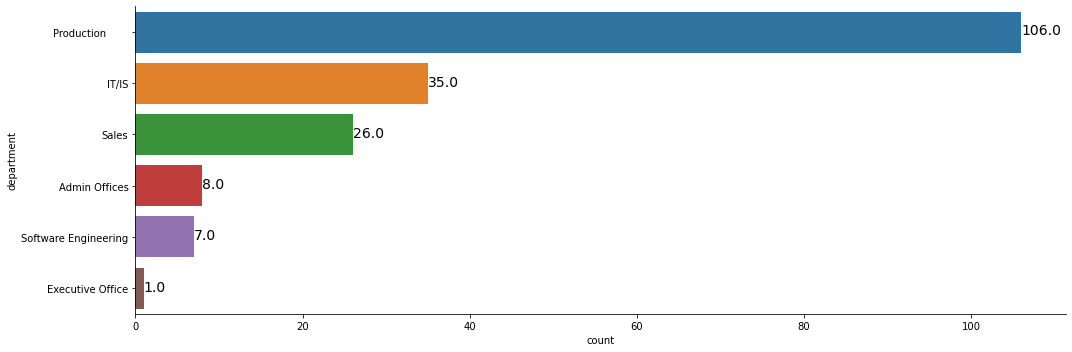

In [8]:
R = """
    SELECT department, COUNT('Employee Number') as count
    FROM hr_dataset
    WHERE "Employment Status" = 'Active'
    GROUP BY department
    ORDER BY count DESC;
    """

bar_categories(sql(R), {'x': 'count', 'y': 'department', 'orient': 'horizontal', 'kind': 'bar'}, )

* Персонал комании, который сейчас работает представлен 183 сотрудниками.
* В соответсвиии с разделением на отделы сотрудники комании распределены следующим образом:
  * производсвенный отдел - 106 человек;
  * ИТ-служба (поддержка) - 35 человек;
  * отдел продаж - 26 человек;
  * управленческий персонал - 8 человек;
  * отдел разработок ПО - 7 человек;
  * ТОП-менеджмент - 1 человек.

## 3.2 Распределение сотрудников по полу и отделам комании

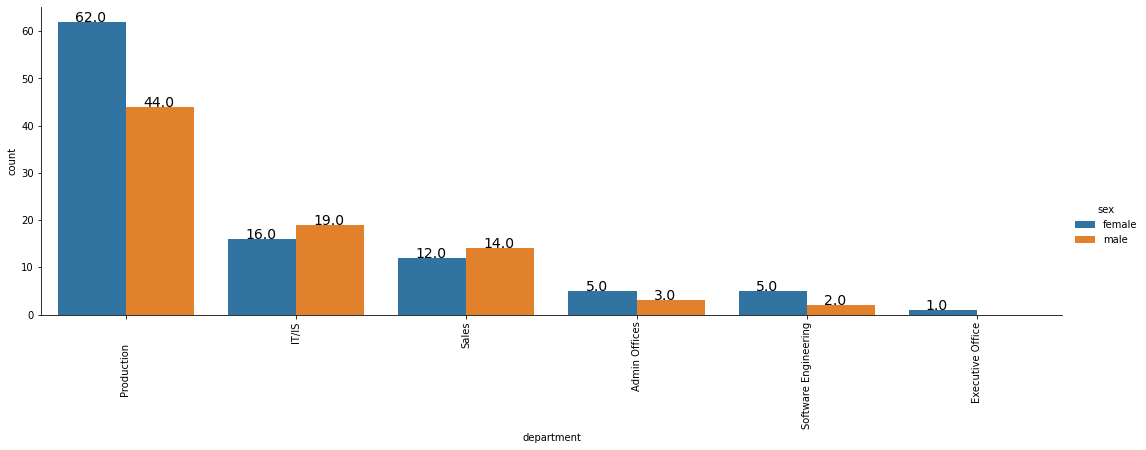

In [9]:
R = """
    SELECT "department", 
    
    CASE WHEN hr_dataset.genderid=1 THEN 'male' 
         WHEN hr_dataset.genderid=0 THEN 'female'
    END AS "sex", 
    
    COUNT("Employee Number") as count
    
    FROM hr_dataset
    WHERE "Employment Status" = 'Active'
    GROUP BY "department", "genderid" 
    ORDER BY count DESC;
    """

bar_categories(sql(R), {'x':'department', 'y': 'count', 'hue':'sex', 'kind': 'bar'}, )

Распределение по половому признаку показывает, что:
* женщины преимущественно представлены в производственном отделе, отделе разработок ПО, управлеческом персонале;
* мужчины - в отделе ИТ-поддержки, продажах и ТОП-менеджменте.

## 3.3. Средний рейтинг сотрудников и СКО в разрезе отделов

## ⚠ Изменения для SQLite
* [SQLite - список агрегирующих функций](https://www.sqlite.org/lang_aggfunc.html)
* Отсутствует функция `STDDEV` - Среднеквадратическое отклонение  

### Решение проблемы:
1. Можно реализовать на SQL расчёт СКО, но есть проблемы с взятием квадратного корня, в SQLite нет поддержки из коробки математической операции возведения в степень.
2. Можно поставить стороннее расширение(модуль), которое добавить дополнительные функции.

### Добавим сторонний модуль:
* Загрузим расширение для [SQLite - extension-functions.c](https://www.sqlite.org/contrib?orderby=date) в котором есть необхадимая функция.
* Для подгрузки модуля потребуется скопилировать dll библиотеку для этого потребуется компилятор используем gcc
  * Скачаем установщик - http://mingw-w64.org/doku.php/download/win-builds
  * Установим его и добавим в Path
  * `gcc -g -shared extension-functions.c -o extension-functions.dll`
  * Скомпиоировано для Win 10 Pro x64 2004
* Изменим функцию SQL - для подгрузки нужного модуля.
* SQL запрос нужно изменить: `STDDEV` на `STDEV`

In [10]:
import os.path
# Нужно прописать прямой путь к библиотеке, PATH не срабатывает в Jupyter
path_to_dll = os.path.join(os.path.abspath('.'), 'extension-functions.dll')

def sql_with_ext(sql_request, dbug=None):
    conn = sqlite3.connect('HR.db')
    # Включаем загрузку расширений и подгружаем скомпилированный модуль
    conn.enable_load_extension(True)
    # Загружаем модуль
    conn.execute(f"""
        SELECT load_extension('{path_to_dll}')""")
    
    cursor = conn.cursor()
    cursor.execute(sql_request)

    columns_name = [i[0] for i in cursor.description]
    data = [j for j in cursor]
    df = pd.DataFrame(data, columns=columns_name)

    if dbug:
        print(columns_name)
        print(data)
    
    conn.commit()
    conn.close()
    return df

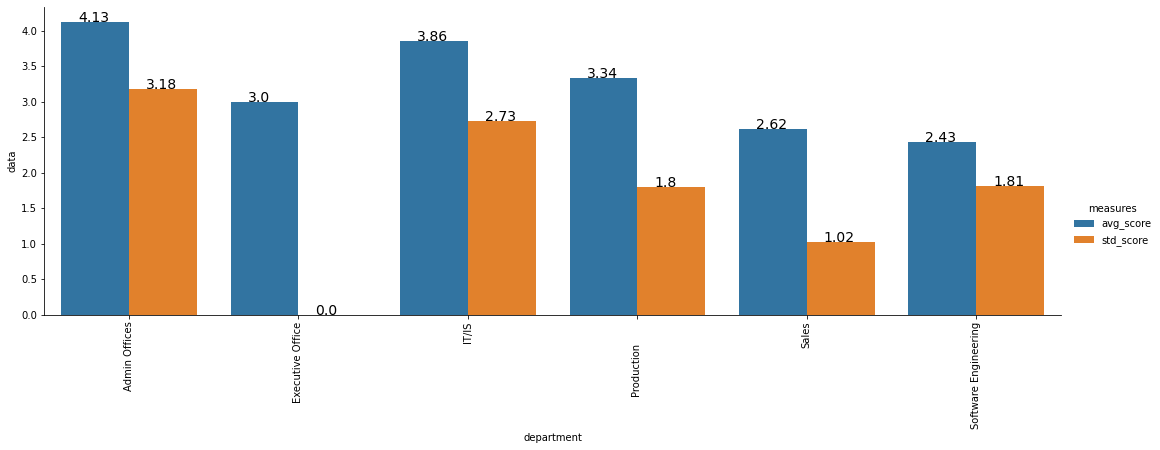

In [11]:
R = """ 
SELECT department, 'avg_score' as measures, avg_score as data
FROM (SELECT "department", ROUND(AVG("perf_scoreid"), 2) as "avg_score"
      FROM hr_dataset
      WHERE "Employment Status" = 'Active'
      GROUP BY "department") AS AGG1

UNION ALL

SELECT department, 'std_score' as measures, std_score as data
FROM (SELECT "department", ROUND(STDEV("perf_scoreid"), 2) as "std_score"
      FROM hr_dataset
      WHERE "Employment Status" = 'Active'
      GROUP BY "department") AS AGG2
   ; """

bar_categories(sql_with_ext(R), {'x':'department', 'y': 'data', 'hue':'measures', 'kind': 'bar'}, table=False)

Оценики персонала по отделам распределены следующим образом:
* Наиболее высокая средняя оценка - соответсвует управленческому персоналу, чтоит отметить, что также она наиболее вариативная (среднеквадратическое отклонение)
* Наиболее низкая оценка соответсвует - отделу разработки ПО.
* Наиболее низкая вариативность в оценке персонала выявлена в отделе продаж, что может говорить, о более продуманной системе KPI и(или) - более эффективном руководстве отделом. 

## 3.4. Средний возраст сотрудников по отделам

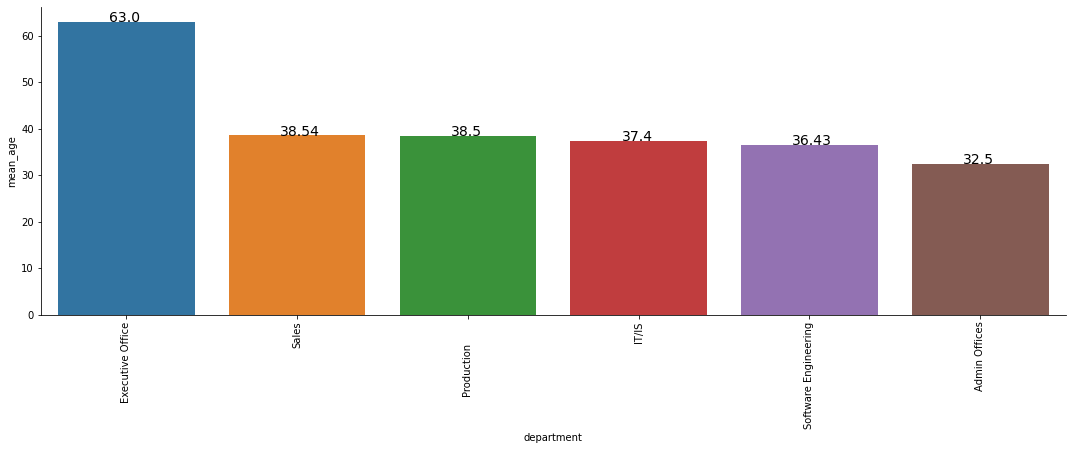

In [12]:
R = """
    SELECT department, AVG(age) as mean_age 
    FROM hr_dataset
    WHERE "Employment Status" = 'Active'
    GROUP BY department
    ORDER BY mean_age DESC 
; """

bar_categories(sql(R), {'x':'department', 'y': 'mean_age', 'kind': 'bar'})

Средний возраст сотрудников по отделам показал:
* Наиболее пожилой сотрудник предствален в ТОП-менеджменте - 63 года.
* В среднем более молодые сотрудники предствалены в управленческом офисе - 32 года.
* В остальных отделах средний возраст колеблится между 36-38 годами.

## 3.5. Средний стаж работы сотрудников по отделам

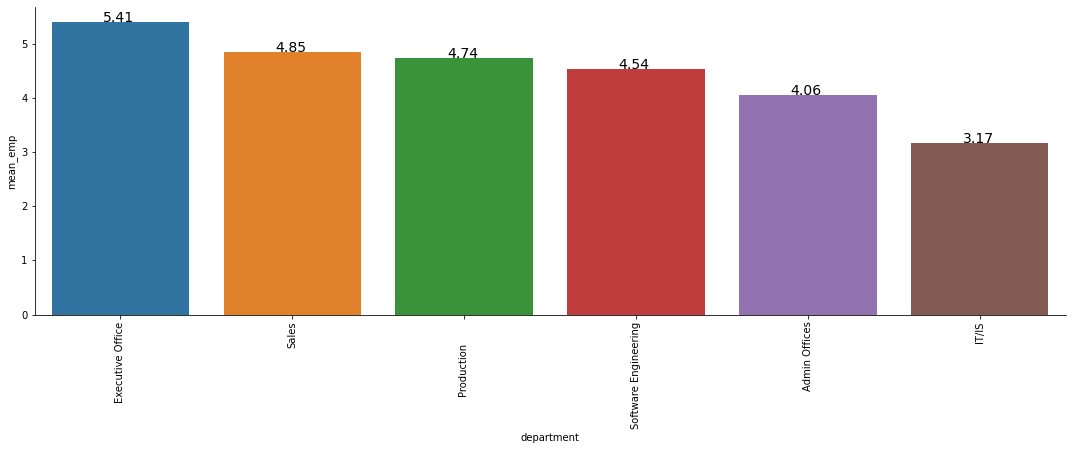

In [13]:
R = """
    SELECT department, AVG("Days Employed")/365 as mean_emp
    FROM hr_dataset
    WHERE "Employment Status" = 'Active'
    GROUP BY department
    ORDER BY mean_emp DESC
; """

bar_categories(sql(R), {'x':'department', 'y': 'mean_emp', 'kind': 'bar'}, )

Распределение среднего стажа сотрудников с группировкой по отделам показала:
* Большая текучесть совойствена ИТ-отделу (поддержка), Офису управления.
* Стабильнее всех работает ТОП-мнеджмент.
* Среднее и близкое занчение опыта (от 4,5 до 5 лет) - показали отделы Продаж, Производства, Разработки ПО.

## 3.6. Распределение национальной принадлежности сотрудников по отделам в процентном соотношении к количеству сотрудников в отделе

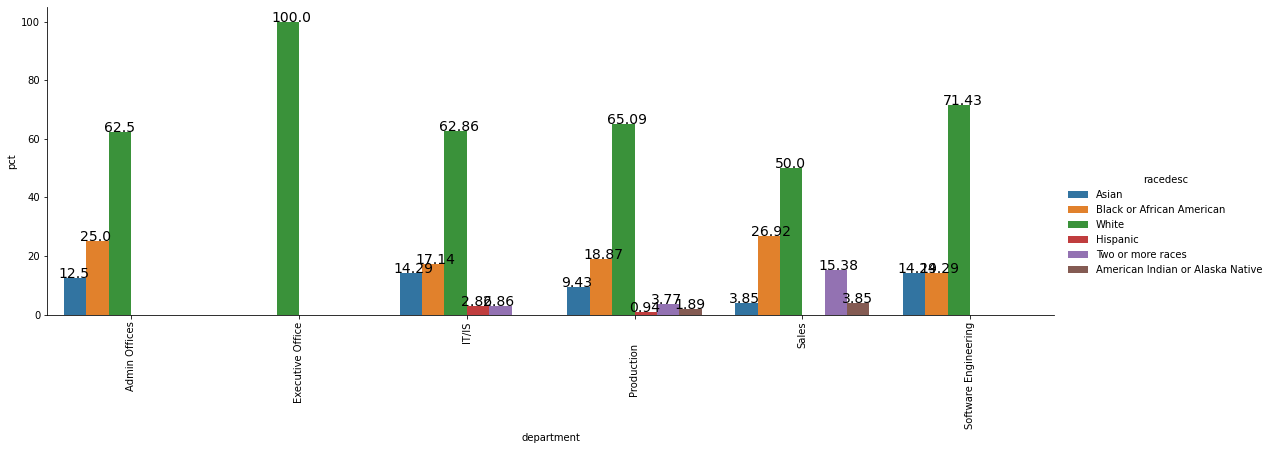

In [14]:
# При делении int на int SQL возвращает INT, обязательно вводить '100.0' - чтобы получить FLOAT, иначе теряются проценты в распаределении
# Создаются две виртуальные таблицы, им присваиваются имена, таблицы имею схождую структуру, объединение происходит по названиями отделов, итоговая таблица состоит из столбцов - департамент, национальность, процент национальности в департаменте
R = """
    SELECT 
    NUM.department, NUM.racedesc, (NUM.ratio*100.0/DEN.total) as pct

    FROM (SELECT department, racedesc, COUNT(racedesc) AS ratio
          FROM hr_dataset
          WHERE "Employment Status" = 'Active'
          GROUP BY department, racedesc
        ) AS NUM

    INNER JOIN (SELECT department, COUNT(racedesc) AS total
                FROM hr_dataset
                WHERE "Employment Status" = 'Active'
                GROUP BY department
        ) AS DEN

    ON NUM.department = DEN.department

  ; """

bar_categories(sql(R), {'x':'department', 'y': 'pct', 'hue':'racedesc', 'kind': 'bar'},  )

Расчёт национальной составляющей в разрезе отделов показал:
* В отделах преобладает белое население.
* Второй наиболее значимой группой является чёрные - афроамериканцы.
* В продажах третье место занимают работники, более чем с одной национальностью.
* В производсте, ИТ-поддержке, Разработке ПО, управлеческом офисе - азиаты.
* Латиноамериканцы, Индейцы, ураженцы Аляски представлены в меншесте во всех отделах.

## 3.7. Площадки найма производственного персонала в т.ч. не работающие сотрудники

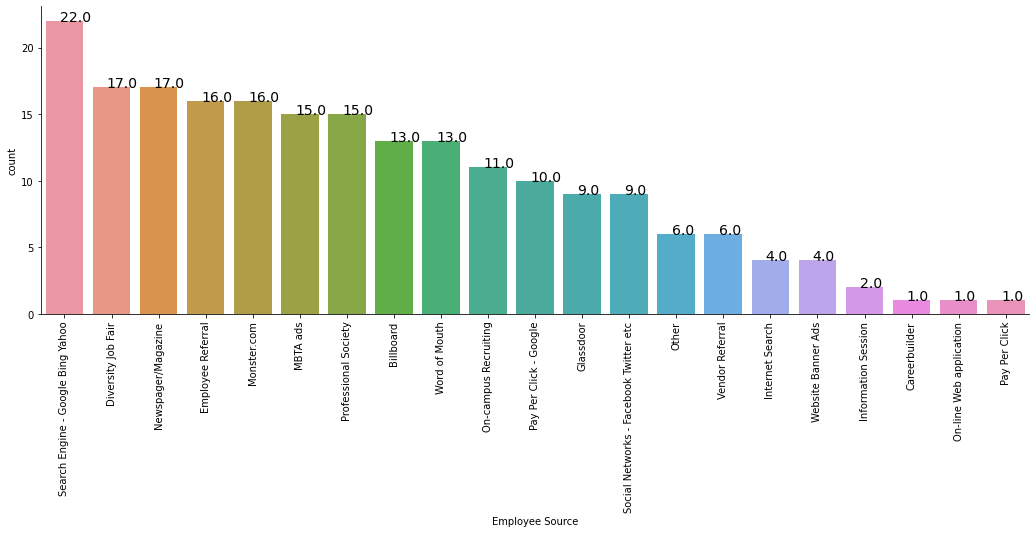

In [15]:
# Странный баг если написать WHERE department = 'Production' - возвращается пустой запрос

R = """
    SELECT department, "Employee Source", COUNT("Employee Source") as count
    FROM hr_dataset
    WHERE department <> 'IT/IS' 
      AND department <> 'Sales' 
      AND department <> 'Admin Offices'
      AND department <> 'Software Engineering'
      AND department <> 'Executive Office'
    GROUP BY "Employee Source", department
    ORDER BY count DESC
    ; """

bar_categories(sql(R), {'x':'Employee Source', 'y': 'count', 'kind': 'bar'}, )

Преимущественно производственный персонал подбирается через:
* Простой поиск в поисковых системах;
* Объявлениях в журналах и газатах;
* Ярморках вакансий;
* На специализированном сайте (monster.com);
* Рекламной сети MBTA;
* Профессиональное сообщество;  

Наименее эффективные средства для найма новых производственных сотрудников:
* Стажировки для студентов;
* Веб-сайт компании;
* Реклсамная сеть с оплатой по отдельным кликам;
* Выступления на конференциях;
* Поиск кандидатами информации в сети;
* Баннерная реклама.

## 3.8. Средние зарплаты сотрудников по отделам (52 рабочие недели по 40 часов) 

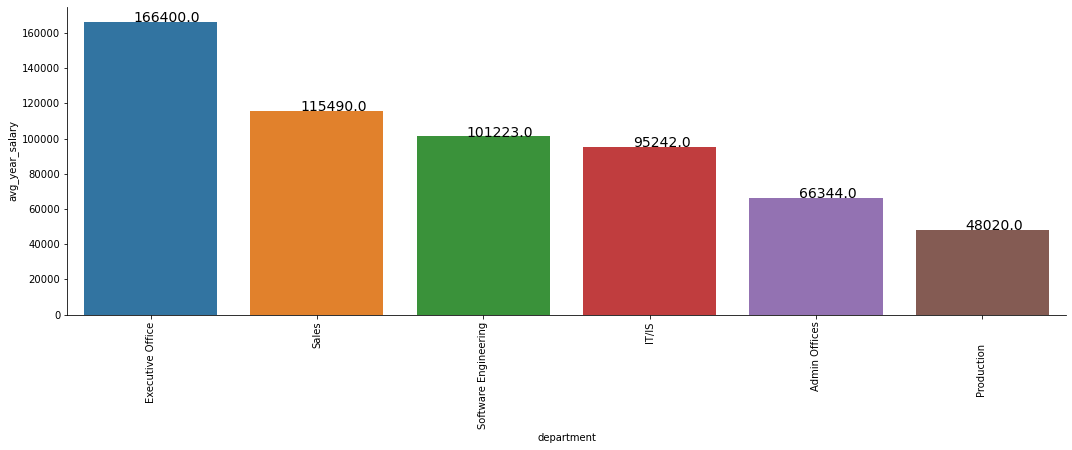

In [16]:
R = """
    SELECT department, ROUND(AVG("Pay Rate"*52*40)) as avg_year_salary
    FROM hr_dataset 
    GROUP BY department
    ORDER BY avg_year_salary DESC
    ; """
bar_categories(sql(R), {'x':'department', 'y': 'avg_year_salary', 'kind': 'bar'}, )

Годовые зарплаты распределены следующим образом:
* Наибольшая у ТОП-менеджера, значительно отличается от всех других отделов.
* Втрое место занимает отдел Продаж - скорее всего получают процент.
* Третье место - Разработчики ПО.
* Наименьшую зарплату получают в производственном отделе (вероятно знаимаются просто сборкой).

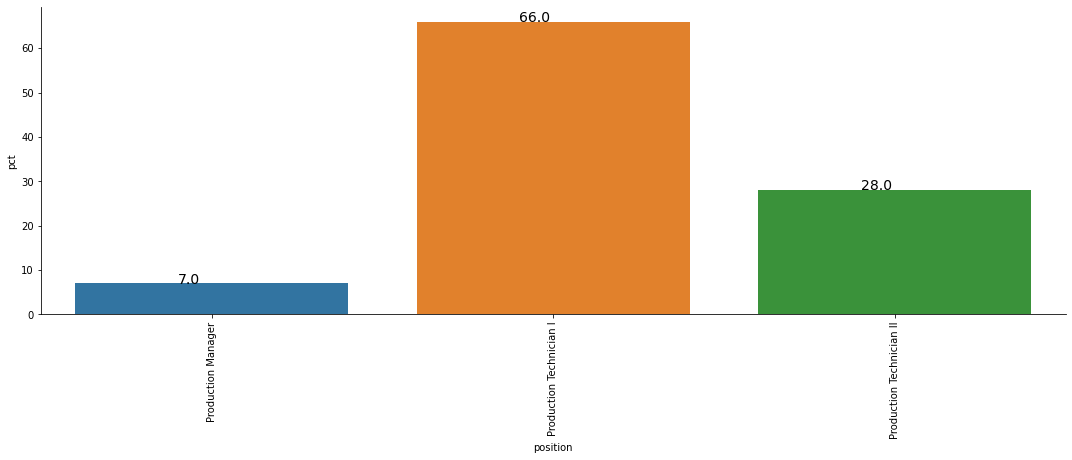

In [17]:
R = """
    SELECT position, round((count*100.0)/total) as pct
    
    FROM
          (SELECT "Position" as position, COUNT("Position") as count
          FROM production_staff
          WHERE id < 210
          GROUP BY "Position") AS num
    
    CROSS JOIN

          (SELECT COUNT("Position") as total
          FROM production_staff
          WHERE id < 210) AS den
   ; """

bar_categories(sql(R), {'x':'position', 'y': 'pct', 'kind': 'bar'}, )

Квалификация работников в производственном отделе:
* Большинство работников на производстве относится к первой категории - 66%.
* 28% ко второй категории.
* Начальники цеха - 7%.

# 4. Проверка гипотез по данным
  * Для визуальной проверки гипотез будем использовать следующие типы графиков:

  #### Для категоральных данных:

    * `box plot` - «ящик с усами» - позволит визуально сопоставить распределение различных величин.
      * `ящик` - расположен между 25 и 75 перцентилью.
      * `усы` - в seaborn рассчитваются как: $X_1 = Q_1 - k(Q_3 - Q_1)$ и $X_2 = Q_3 + k(Q_3 - Q_1)$, где k = 1,5
    * `boxen plot` - `Letter-value plots` схож с `box plot`. Рекомендуется применять при размере датасета от 200 значений.
      * Блоки расположены друг над другом - ширина блока выбирается произвольно.
      * Самый широкий блок расположен между 25 и 75 перцентилем\квартилем.
      * остальные расположены между другими (вероятно деляет на 8 частей).  
    * `catplot` - функция высокого уровня (по сравнению с `boxplot` и `boxenplot`), принимающая тип (`kind`) определяющая вид графика.
    * [Документация - визуализация категоральных данных](https://seaborn.pydata.org/tutorial/categorical.html#categorical-tutorial)
  
  #### Для НЕкатегоральных данных:
    * `scaterplot` - отражает объединённое распределение двух случайных величин на плоскости в виде точек.
      * `hue` - параметр позволит раскрасить точки в цвета разных категорий.
      * `style` - задаст для различных категорий различные маркеры.
    * `lineplot` - одна из переменных рассматривается как непрерывная переменная, например время или нечто аналогичное.
      * Если данных много выводит по умолчанию линию и границу доверительного интервала 95%, можно выводить размах вариации параметр - `ci="sd"`.
    * `relplot` - функция высокого уровня может отрисовывать `scatterplot()` & `lineplot()`
    * [Документация - визуализация НЕкатегоральных данных](https://seaborn.pydata.org/tutorial/relational.html#relational-tutorial)

    

In [18]:
def box_plot(sql_r, param, table=None):
    """
    Функция отрисовки диаграммы рассеивания, общеприято, что на горизонательной оси откладывается независимая переменная
      * input: df - pandas.DataFrame, param - {'x': 'name', ....}, table - показывать ли датафрейм
      * return: None
    """
    g = sns.catplot(
        x      = param.setdefault('x', None),
        y      = param.setdefault('y', None),
        hue    = param.setdefault('hue', None),
        kind   = param.setdefault('kind', 'box'),
        data   = sql_r,
        size   = 3,
        height = param.setdefault('height', 7),
        aspect = param.setdefault('aspect', 7))
    # поворот подписей данных
    g.set_xticklabels(rotation=90)

    # Вывод точек на график (построение второго графика нповерх первого по тем же данным)
    g = sns.stripplot(
        x      = param.setdefault('x', None),
        y      = param.setdefault('y', None),
        hue    = param.setdefault('hue', None),
        data   = sql_r,
        size   = 3,
        color  = 'black')

    if table:
        display(sql_r)

In [19]:
def scatter_plot(sql_r, param, table=None):
    """
    Функция отрисовки диаграммы рассеивания, общеприято, что на горизонательной оси откладывается независимая переменная
      * input: df - pandas.DataFrame, param - {'x': 'name', ....}, table - показывать ли датафрейм
      * return: None
    """
    g = sns.relplot(
        x      = param.setdefault('x', None),
        y      = param.setdefault('y', None),
        hue    = param.setdefault('hue', None),
        kind   = 'scatter',
        data   = sql_r,
        height = param.setdefault('height', 7),
        aspect = param.setdefault('aspect', 7))

    if table:
        display(sql_r)

## 4.1 Зависимость между `perfomance score` и тем, под чьим руководством работает сотрудник

C:\Miniconda3\envs\an38\lib\site-packages\seaborn\categorical.py:3692: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


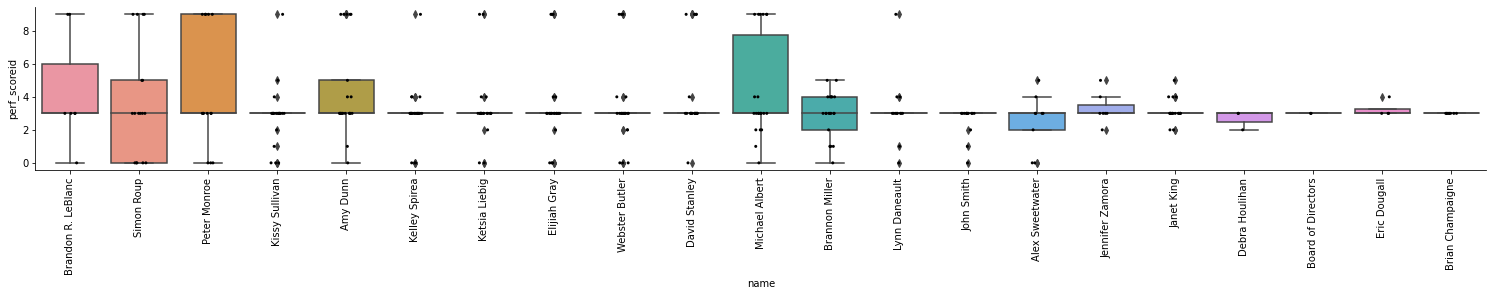

In [20]:
R = """
    SELECT "Manager Name" as name, perf_scoreid
    FROM hr_dataset
    ORDER BY "perf_scoreid"

   ; """
box_plot(sql(R), {'x':'name', 'y':'perf_scoreid', 'kind':'box'})

## 4.1(доп) Расчёт коэфицента корреляции рангов Спирмена - **Менеджер и рейтинг сотрудника**
1. Имя менеджера - сортируем и присваимваем порядковый номер функция `ROW_NUMBER ()` т.к. имена повтаряются, нужно считать средний ранг - сделаем группировку и округлим значения
2. Сделаем аналогичные действия для рейтинга работника - сортировка по рейтингу работника и рассчёт рангов.
3. Данные операции оформим в виде `временных таблиц` для упрощения SQL запроса: `names_range` & `scores_range`
4. Создадим `основную` временную таблицу к которой будем присоеденять данные из ранее созданных таблиц:  
  * _Имя менеджера(Alex, ...) - ранг_ - `names_range = nr`  
  * _Оценка сотрудника(от 0 до 9) - ранг_ - `scores_range = sr`  
5. Итоговый запрос: составим таблицу: **Сотрудник (имя) - ранг-менеджера - ранг-оценки-сотрудника**
6. Рассчитаем коэфициент по формуле:  
* $p_s = 1 - \frac{6\sum_{i=1}^n{d_i^2}}{n(n^2-1)}$
* $d(i)^2$ - разница между рангами $281-16=265$, $265^2=70225$
* числитель $n(n^2-1)$ = $310 * (310^2 - 1)$


## ⚠ Изменения для SQLite
* SQLite - выдаёт ошибку `OperationalError: near "INTO": syntax error`
* `SELECT INTO` - Создаёт таблицу из запроса и работает в PostgreSQL, но не поддерживается в SQLite
* Скорректируем SQL запрос:
  * `SELECT * INTO TEMP TABLE table_name FROM ...` на 
  * `CREATE TEMP TABLE table_name AS SELECT * FROM ...`
* Допишем `as row_number` т.к. не присваивается автоматичсеки название для столбца при применении функции `row_number()` в SQLite
* `execute()` will only execute a single SQL statement. Скорректируем SQL Функцию, чтобы выполнять несколько запросов к БД - `executescript(sql)` - выполнит скрипт, но ничего не вернёт, по этому последнй шаг расчёта перенесём в функцию.
* Для расчёта потребуется возведение в степень, подгрузим сторонний модуль скомпилированный ранее, в котром есть данная функция.

In [21]:
def sql_script(sql_request, dbug=None):
    conn = sqlite3.connect('HR.db') 
    conn.enable_load_extension(True)
    # Загружаем модуль
    conn.execute(f"""
        SELECT load_extension('{path_to_dll}')""")
    cursor = conn.cursor()
    # Изменение
    cursor.executescript(sql_request) # Изменена команда ⚠ cursor.execute(sql_request)
    
    # Вынесена часть расчётов
    cursor.execute("""
        SELECT (1-SUM(di)) 
               /
        (COUNT(di)*(POWER(COUNT(di),2) - 1))
    AS Spearman_corr
    FROM agg_table
   ; 
    """)
    
    columns_name = [i[0] for i in cursor.description]
    data = [j for j in cursor]
    df = pd.DataFrame(data, columns=columns_name)

    if dbug:
        print(columns_name)
        print(data)
    
    conn.commit()
    conn.close()
    return df

In [22]:
R = """
    CREATE TEMP TABLE names_range 
    AS SELECT names.name, AVG(ROUND(row_number)) as avg_rang_name
    FROM 
        (SELECT
        "Manager Name" as name,
            ROW_NUMBER() OVER (ORDER BY "Manager Name") as row_number
        FROM hr_dataset
        ORDER BY "Manager Name") AS names
    GROUP BY "name";


    CREATE TEMP TABLE scores_range 
    AS SELECT perf_scoreid_all.perf_scoreid, AVG(ROUND(row_number)) as avg_rang_perf_scoreid
    FROM 
        (SELECT
        perf_scoreid,
            ROW_NUMBER() OVER (ORDER BY "perf_scoreid") as row_number
        FROM hr_dataset
        ORDER BY "perf_scoreid") AS perf_scoreid_all
    GROUP BY "perf_scoreid";


    CREATE TEMP TABLE main_table 
    AS SELECT "Employee Name" as emp_name, "Manager Name" as manager_name, perf_scoreid
    FROM hr_dataset
    ORDER BY "Manager Name";


    CREATE TEMP TABLE agg_table
    AS SELECT mt.emp_name, mt.manager_name, mt.perf_scoreid, nr.avg_rang_name, sr.avg_rang_perf_scoreid, POWER((nr.avg_rang_name - sr.avg_rang_perf_scoreid),2) as di
    FROM main_table AS mt
    INNER JOIN names_range AS nr
        ON nr.name = mt.manager_name
    INNER JOIN scores_range AS sr
        ON sr.perf_scoreid = mt.perf_scoreid;

    """

sql_script(R)

,Spearman_corr
0,-0.15325


### Решение для PostgreSQL

In [23]:
R = """
    SELECT names.name, AVG(ROUND(row_number)) as avg_rang_name
    INTO TEMP TABLE names_range
    FROM 
        (SELECT
        "Manager Name" as name,
            ROW_NUMBER () OVER (ORDER BY "Manager Name")
        FROM hr_dataset
        ORDER BY "Manager Name") AS names
    GROUP BY "name";


    SELECT perf_scoreid_all.perf_scoreid, AVG(ROUND(row_number)) as avg_rang_perf_scoreid
    INTO TEMP TABLE scores_range
    FROM 
        (SELECT
        perf_scoreid,
            ROW_NUMBER () OVER (ORDER BY "perf_scoreid")
        FROM hr_dataset
        ORDER BY "perf_scoreid") AS perf_scoreid_all
    GROUP BY "perf_scoreid";


    SELECT "Employee Name" as emp_name, "Manager Name" as manager_name, perf_scoreid
    INTO TEMP TABLE main_table
    FROM hr_dataset
    ORDER BY "Manager Name";


    SELECT mt.emp_name, mt.manager_name, mt.perf_scoreid, nr.avg_rang_name, sr.avg_rang_perf_scoreid, (nr.avg_rang_name - sr.avg_rang_perf_scoreid)^2 as di
    INTO TEMP TABLE agg_table
    FROM main_table AS mt
    INNER JOIN names_range AS nr
        ON nr.name = mt.manager_name
    INNER JOIN scores_range AS sr
        ON sr.perf_scoreid = mt.perf_scoreid;


    SELECT (1-SUM(di))
               /
        (COUNT(di)*(COUNT(di)^2 - 1))
    AS Spearman_corr
    FROM agg_table

   ; """

# sql(R)

### Вывод
* Графики распределения оценок работников по менеджерам показывают, что оценки распределены весьма разнообразно.
* Питер, Брендон и Майкл - распределение смещено к более высоким оценкам.
* Коэффициент раноговой корреляции Спирмена показал слабую обратную связь между менеджером и выставляемой оценкой сотрудникам.

## 4.2 Зависимость между продолжительностью работы в компании и семейным положением сотрудника

C:\Miniconda3\envs\an38\lib\site-packages\seaborn\categorical.py:3692: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


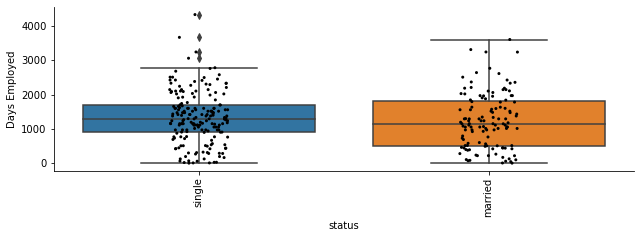

In [24]:
R = """
    SELECT "Days Employed",
       CASE WHEN hr_dataset.marriedid=0 THEN 'single'
            WHEN hr_dataset.marriedid=1 THEN 'married'
       END AS status

    FROM hr_dataset
    ORDER BY "Days Employed" DESC

   ; """
   
sql(R)

box_plot(sql(R), {'x':'status', 'y':'Days Employed', 'kind':'box', 'aspect':3})

### Вывод
* Графики показывают, что в выборке `одиноких` работников больше выбросов, чем у тех у `семейных`
* `Семейные` - распределение более смещено к левому концу, что может говорить о том, что люди с таким статусом работают в компании меньше чем одинокии, т.е. менее продолжительное время.

## 4.3 Зависимость между продолжительностью работы в компании и возрастом сотрудника

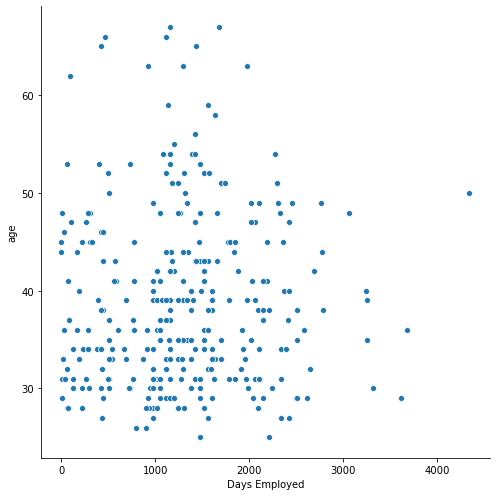

In [25]:
R = """
    SELECT "Days Employed", age

    FROM hr_dataset
    ORDER BY "age"

   ; """
   
sql(R)

scatter_plot(sql(R), {'x':'Days Employed', 'y':'age', 'aspect':1})

### Вывод
* Кикие-либо выводы сделать не получается.

## 4.4 Зависимость между заработной платой и семейным положением

C:\Miniconda3\envs\an38\lib\site-packages\seaborn\categorical.py:3692: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


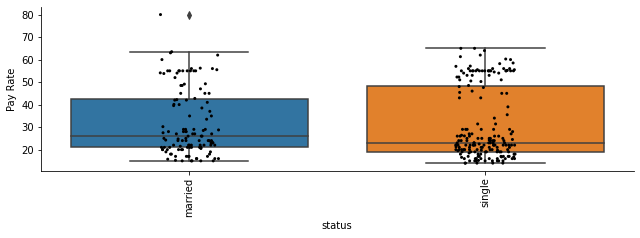

In [26]:
R = """
    SELECT "Days Employed", "Pay Rate",
       CASE WHEN hr_dataset.marriedid=0 THEN 'single'
            WHEN hr_dataset.marriedid=1 THEN 'married'
       END AS status

    FROM hr_dataset
    ORDER BY "Pay Rate" DESC

   ; """
   
sql(R)

box_plot(sql(R), {'x':'status', 'y':'Pay Rate', 'kind':'box', 'aspect':3})

### Вывод
* Медиана в обоих ящиках смещещена к нижней части, что говорит об ассиметрии.
* `Семейные` - ящик меньше, чем `одинокие`, что говорит, о большем центрирование скопления сотрудников.
* `Одинокие` - ящик щире, а выведенные точки позволяют предоложить наличие двух центров в группе, что можно исследовать более глубоко и выделить третью группу.

## 4.5 Зависимость между оценкой сотрудника и площадкой, через которую он устроился на работу

C:\Miniconda3\envs\an38\lib\site-packages\seaborn\categorical.py:3692: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


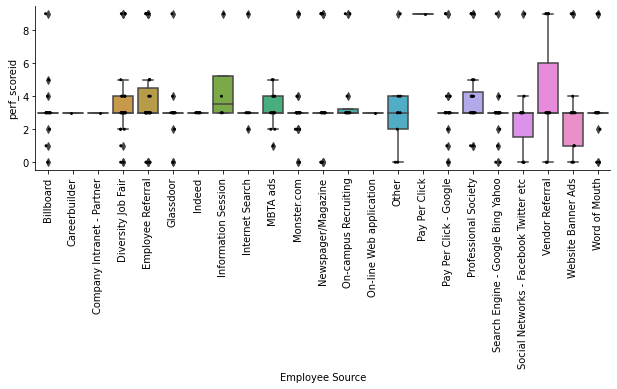

In [27]:
R = """
    SELECT "Employee Source", "perf_scoreid", "Pay Rate"

    FROM hr_dataset
    ORDER BY "Employee Source"

   ; """

box_plot(sql(R), {'x':'Employee Source', 'y':'perf_scoreid', 'kind':'box', 'aspect':3})

### Вывод
* Работники пришедшие в команию с социальных сетей и от банерной рекламы скорее имеют более низкие оценки их работы.
* Более высокие оценки свойствены тем, кто пришел в команию через `information session` - медиана смещена выше.

## 4.6 Зависимость между часовой оплатой сотрудника и площадкой, через которую он устроился на работу

C:\Miniconda3\envs\an38\lib\site-packages\seaborn\categorical.py:3692: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


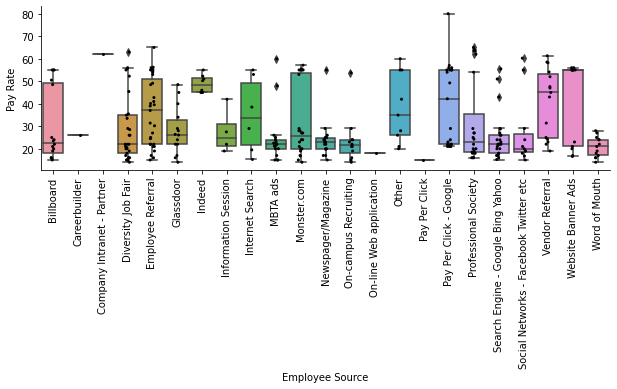

In [28]:
R = """
    SELECT "Employee Source", "perf_scoreid", "Pay Rate"

    FROM hr_dataset
    ORDER BY "Employee Source"

   ; """
   
sql(R)

box_plot(sql(R), {'x':'Employee Source', 'y':'Pay Rate', 'kind':'box', 'aspect':3})

### Вывод
* Есть отдельные площадки люди пришедшие с которых получают очень компактно распределённую почасовую оплату.
* Часть площадко покзывает наоборот - большую вариативность заработных плат.

## 4.7 Зависимость между статусом сотрудника (работает\уволен\и т.д.) и почасовой оплатой

C:\Miniconda3\envs\an38\lib\site-packages\seaborn\categorical.py:3692: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


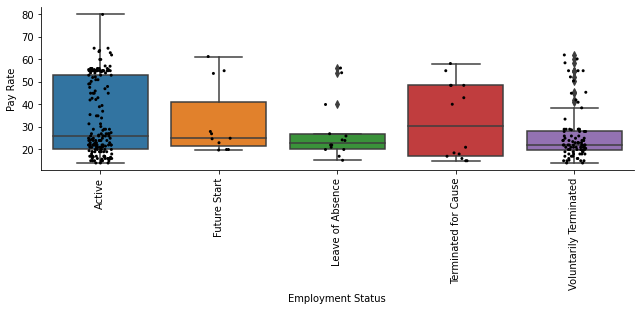

In [29]:
R = """
    SELECT "Employment Status", "perf_scoreid", "Pay Rate"

    FROM hr_dataset
    ORDER BY "Employment Status"

   ; """
   
sql(R)

box_plot(sql(R), {'x':'Employment Status', 'y':'Pay Rate', 'kind':'box', 'aspect':3})

### Вывод
* Уволеные по собственному желанию `Voluntarily Term` - значительное количество выбросов по сравненею с другими категориями.
* А нанесенённые точки позволяют также выявить две категории: (1) - выбросы - вероятно уволились по неизветным причинам, (2) - причиной ухода других могла быть низкая ставка оплаты труда.